# Coursera ML Final Asignment - Classification Models

### Import libraries

In [1]:
import pandas as pd
import pandas as pd
import numpy as np 

import seaborn as sns 
import matplotlib.pylab as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline

from scipy.stats import norm
from scipy import stats
from scipy.stats import chi2_contingency

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm 

### Download data

In [2]:
path = '/Users/kristine/Documents/Coursera/2. IBM Machine Learning/2. Projects/drug200.csv'
df = pd.read_csv(path)
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,drugY


### Data cleansing

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


In [4]:
#1. Identify number of unique values for each column
df_uniques = pd.DataFrame([[i, len(df[i].unique())] for i in df.columns], columns=['Variable', 'Unique Values']).set_index('Variable')
df_uniques

,Unique Values
Variable,
Age,57
Sex,2
BP,3
Cholesterol,2
Na_to_K,198
Drug,5


In [5]:
#2. Identify binary variables based on criteria that they have just two types of unique values (later for them values can be set to 0 and 1)
binary_variables = list(df_uniques[df_uniques['Unique Values'] == 2].index)
binary_variables

['Sex', 'Cholesterol']

In [6]:
#3. Identify categorical variables 
categorical_variables = list(df_uniques[(6 >= df_uniques['Unique Values']) & (df_uniques['Unique Values'] > 2)].index)
categorical_variables

['BP', 'Drug']

In [7]:
[[i, list(df[i].unique())] for i in categorical_variables]

[['BP', ['HIGH', 'LOW', 'NORMAL']],
 ['Drug', ['drugY', 'drugC', 'drugX', 'drugA', 'drugB']]]

In [8]:
#4. Remaining are assumed to be numerical variables
numeric_variables = list(set(df.columns) - set(categorical_variables) - set(binary_variables))
df[numeric_variables]

,Na_to_K,Age
0,25.355,23
1,13.093,47
2,10.114,47
3,7.798,28
4,18.043,61
...,...,...
195,11.567,56
196,12.006,16
197,9.894,52
198,14.020,23


array([[<AxesSubplot:title={'center':'Na_to_K'}>,
        <AxesSubplot:title={'center':'Age'}>]], dtype=object)

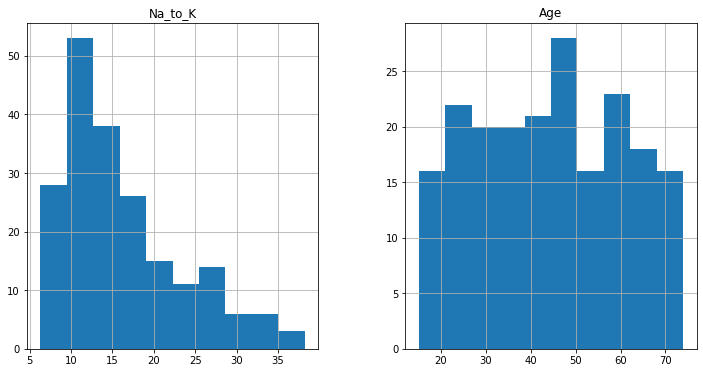

In [9]:
#4.1 Histograms
df[numeric_variables].hist(figsize=(12, 6))

In [10]:
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,drugY


### Data transformation

In [11]:
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OrdinalEncoder

In [12]:
lb, le = LabelBinarizer(), LabelEncoder()

In [13]:
for column in binary_variables:
    df[column] = lb.fit_transform(df[column])

In [14]:
for column in categorical_variables:
    df[column] = le.fit_transform(df[column])

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    int64  
 2   BP           200 non-null    int64  
 3   Cholesterol  200 non-null    int64  
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    int64  
dtypes: float64(1), int64(5)
memory usage: 9.5 KB


In [16]:
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,0,0,0,25.355,4
1,47,1,1,0,13.093,2
2,47,1,1,0,10.114,2
3,28,0,2,0,7.798,3
4,61,0,1,0,18.043,4


In [17]:
from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler()

In [23]:
df['Age'] = (df['Age'] - df ['Age'].min())/(df ['Age'].max() - df ['Age'].min())

In [24]:
df['Na_to_K'] = (df['Na_to_K'] - df ['Na_to_K'].min())/(df ['Na_to_K'].max() - df ['Na_to_K'].min())

In [25]:
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,0.135593,0,0,0,0.596848,4
1,0.542373,1,1,0,0.213397,2
2,0.542373,1,1,0,0.120239,2
3,0.220339,0,2,0,0.047814,3
4,0.779661,0,1,0,0.368191,4


In [136]:
df.describe()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,0.496864,0.520000,0.910000,0.485000,0.306945,2.870000
std,0.280412,0.500854,0.821752,0.501029,0.225904,1.372047
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.271186,0.000000,0.000000,0.000000,0.130605,2.000000
50%,0.508475,1.000000,1.000000,0.000000,0.239774,3.000000
75%,0.728814,1.000000,2.000000,1.000000,0.410001,4.000000
max,1.000000,1.000000,2.000000,1.000000,1.000000,4.000000


### Exloratory data analysis

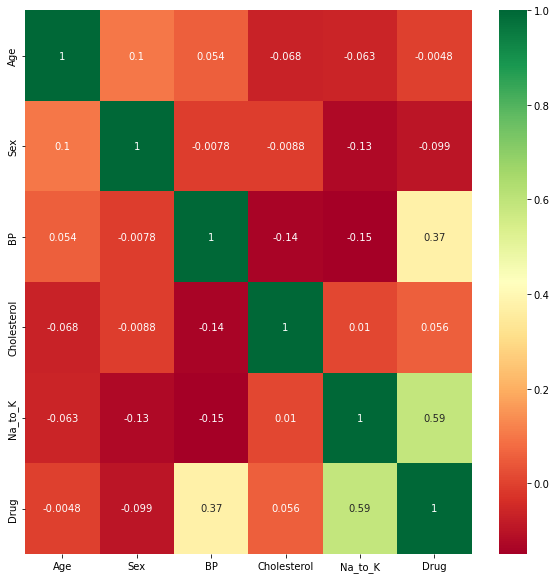

In [26]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(),annot=True,cmap='RdYlGn')

plt.show()

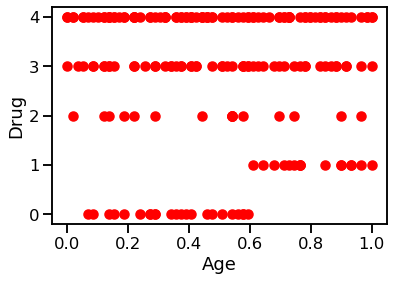

In [31]:
plt.scatter(df['Age'], df['Drug'],  color='red')
plt.xlabel("Age")
plt.ylabel("Drug")
plt.show()

In [42]:
df[['Drug','Sex']].value_counts()       

Drug  Sex
4     0      47
      1      44
3     0      27
      1      27
0     1      14
1     1      10
0     0       9
2     1       9
      0       7
1     0       6
dtype: int64

In [137]:
df[['Drug','BP']].value_counts()

Drug  BP
4     0     38
3     2     36
4     1     30
0     0     23
4     2     23
3     1     18
1     0     16
2     1     16
dtype: int64

In [56]:
df[['Drug','Cholesterol']].value_counts()

Drug  Cholesterol
4     0              47
      1              44
3     1              34
      0              20
2     0              16
0     0              12
      1              11
1     0               8
      1               8
dtype: int64

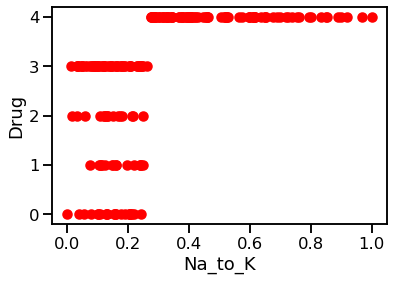

In [57]:
plt.scatter(df['Na_to_K'], df['Drug'],  color='red')
plt.xlabel("Na_to_K")
plt.ylabel("Drug")
plt.show()

### Model 1: KNN

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score

In [59]:
# Set up X and y variables
y, X = df['Drug'], df.drop(columns='Drug')
# Split the data into training and test samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [61]:
# Estimate KNN model and report outcomes
knn = KNeighborsClassifier(n_neighbors=3)
knn = knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
# Preciision, recall, f-score from the multi-class support function
print(classification_report(y_test, y_pred))
print('Accuracy score: ', round(accuracy_score(y_test, y_pred), 2))
print('F1 Score: ', round(f1_score(y_test, y_pred), 2))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.50      0.83      0.62         6
           2       0.67      0.67      0.67         6
           3       0.85      0.88      0.86        25
           4       0.82      0.70      0.75        33

    accuracy                           0.78        80
   macro avg       0.73      0.78      0.74        80
weighted avg       0.79      0.78      0.78        80

Accuracy score:  0.78
F1 Score:  0.78


Text(0.5, 40.5, 'Ground Truth')

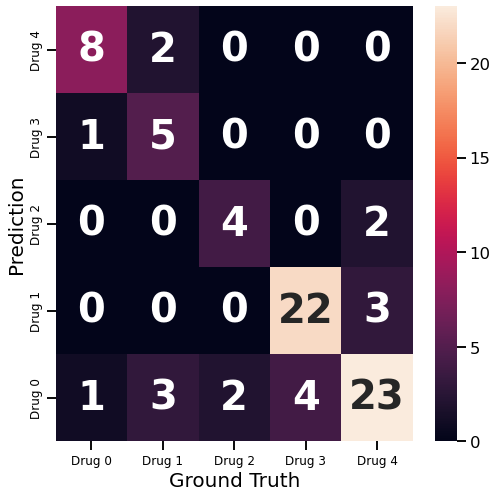

In [68]:
# Plot confusion matrix
sns.set_palette(sns.color_palette())
_, ax = plt.subplots(figsize=(8,8))
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', annot_kws={"size": 40, "weight": "bold"})  
labels = ['Drug 0', 'Drug 1', 'Drug 2', 'Drug 3', 'Drug 4']
ax.set_xticklabels(labels, fontsize=12);
ax.set_yticklabels(labels[::-1], fontsize=12);
ax.set_ylabel('Prediction', fontsize=20);
ax.set_xlabel('Ground Truth', fontsize=20)
### END SOLUTION

In [71]:
### BEGIN SOLUTION
max_k = 40
f1_scores = list()
error_rates = list() # 1-accuracy

for k in range(1, max_k):
    
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
    knn = knn.fit(X_train, y_train)
    
    y_pred = knn.predict(X_test)
    f1 = f1_score(y_pred, y_test, average='weighted')
    f1_scores.append((k, round(f1_score(y_test, y_pred, average='weighted'), 4)))
    error = 1-round(accuracy_score(y_test, y_pred), 4)
    error_rates.append((k, error))
    
f1_results = pd.DataFrame(f1_scores, columns=['K', 'F1 Score'])
error_results = pd.DataFrame(error_rates, columns=['K', 'Error Rate'])

<Figure size 1800x1200 with 0 Axes>

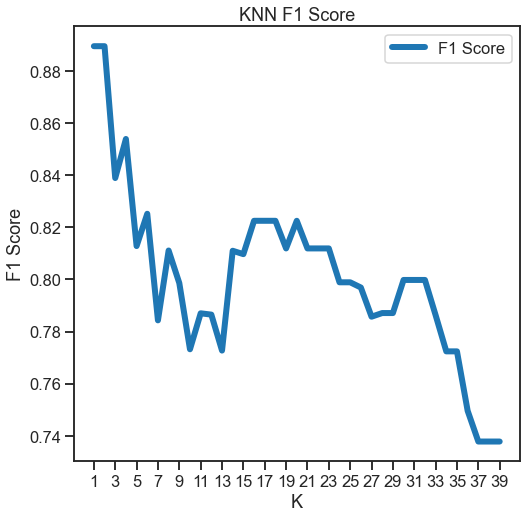

In [119]:
# Plot F1 results
sns.set_context('talk')
sns.set_style('ticks')

plt.figure(dpi=300)
ax = f1_results.set_index('K').plot(figsize=(8, 8), linewidth=6)
ax.set(xlabel='K', ylabel='F1 Score')
ax.set_xticks(range(1, max_k, 2));
plt.title('KNN F1 Score')
plt.savefig('knn_f1.png')

<Figure size 1800x1200 with 0 Axes>

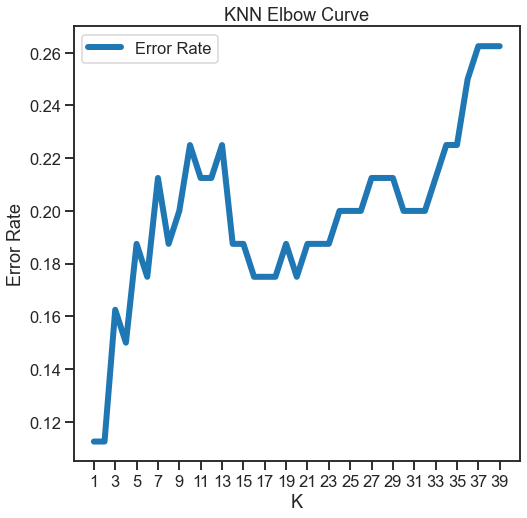

In [120]:
# Plot Accuracy (Error Rate) results
sns.set_context('talk')
sns.set_style('ticks')

plt.figure(dpi=300)
ax = error_results.set_index('K').plot(figsize=(8, 8), linewidth=6)
ax.set(xlabel='K', ylabel='Error Rate')
ax.set_xticks(range(1, max_k, 2))
plt.title('KNN Elbow Curve')
plt.savefig('knn_elbow.png')
### END SOLUTION

In [75]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score

Ks = 40
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
for n in range(1,Ks):
    #Train Model and Predict  
    KNN = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=KNN.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
mean_acc

array([0.8875, 0.8   , 0.775 , 0.75  , 0.725 , 0.6125, 0.5875, 0.575 ,
       0.6125, 0.6125, 0.625 , 0.625 , 0.6875, 0.625 , 0.725 , 0.7   ,
       0.7125, 0.7   , 0.7125, 0.7125, 0.725 , 0.7   , 0.7125, 0.7375,
       0.725 , 0.725 , 0.7125, 0.6625, 0.6125, 0.575 , 0.5625, 0.575 ,
       0.5875, 0.575 , 0.525 , 0.5375, 0.525 , 0.5   , 0.5125])

In [76]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was with 0.8875 with k= 1


### Model 2: DecisionTree

In [77]:
from sklearn.tree import DecisionTreeClassifier
import sklearn.tree as tree

In [79]:
Tree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
Tree # it shows the default parameters
Tree.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [81]:
predTree = Tree.predict(X_test)


In [83]:
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, predTree))

DecisionTrees's Accuracy:  1.0


In [84]:
#nodes and depth
Tree.tree_.node_count, Tree.tree_.max_depth

(11, 4)

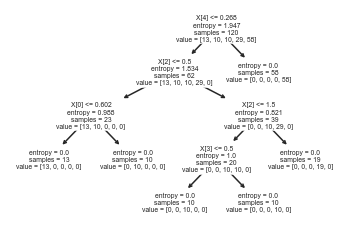

In [90]:
tree.plot_tree(Tree)
plt.show()

In [139]:
df.loc[:4]

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,0.135593,0,0,0,0.596848,4
1,0.542373,1,1,0,0.213397,2
2,0.542373,1,1,0,0.120239,2
3,0.220339,0,2,0,0.047814,3
4,0.779661,0,1,0,0.368191,4


In [93]:
print(classification_report(y_test, predTree))
print('Accuracy score: ', round(accuracy_score(y_test, predTree), 2))
print('F1 Score: ', round(f1_score(y_test, predTree, average='weighted'), 2))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00        25
           4       1.00      1.00      1.00        33

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80

Accuracy score:  1.0
F1 Score:  1.0


### Model3: Random Forest

In [94]:
df_forest = pd.read_csv(path)
df_forest.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,drugY


In [95]:
#train-test-split
y_rf, X_rf = df['Drug'], df.drop(columns='Drug')
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (120, 5) (120,)
Test set: (80, 5) (80,)


In [109]:
#model
from sklearn.ensemble import RandomForestClassifier

RC = RandomForestClassifier(n_estimators=5)

RC = RC.fit(X_train_rf, y_train_rf)
y_predict_rf = RC.predict(X_test_rf)

In [110]:
#functions for accurecy metrics 
def get_accuracy(X_train, X_test, y_train, y_test, model):
    return  {"test Accuracy":metrics.accuracy_score(y_test, model.predict(X_test)),"trian Accuracy": metrics.accuracy_score(y_train, model.predict(X_train))}


def get_correlation(X_test, y_test,models):
    #This function calculates the average correlation between predictors  
    n_estimators=len(models.estimators_)
    prediction=np.zeros((y_test.shape[0],n_estimators))
    predictions=pd.DataFrame({'estimator '+str(n+1):[] for n in range(n_estimators)})
    
    for key,model in zip(predictions.keys(),models.estimators_):
        predictions[key]=model.predict(X_test.to_numpy())
    
    corr=predictions.corr()
    print("Average correlation between predictors: ", corr.mean().mean()-1/n_estimators)
    return corr

In [111]:
#result
print(get_accuracy(X_train_rf, X_test_rf, y_train_rf, y_test_rf, RC))

get_correlation(X_test_rf, y_test_rf,RC).style.background_gradient(cmap='coolwarm')

{'test Accuracy': 0.925, 'trian Accuracy': 0.99375}
Average correlation between predictors:  0.6090004311321882


,estimator 1,estimator 2,estimator 3,estimator 4,estimator 5
estimator 1,1.000000,0.972419,0.685484,0.721982,0.953749
estimator 2,0.972419,1.000000,0.736327,0.711386,0.937377
estimator 3,0.685484,0.736327,1.000000,0.591923,0.629661
estimator 4,0.721982,0.711386,0.591923,1.000000,0.672198
estimator 5,0.953749,0.937377,0.629661,0.672198,1.000000


In [112]:
from sklearn.model_selection import GridSearchCV
model = RandomForestClassifier()
model.get_params().keys()

param_grid = {'n_estimators': [2*n+1 for n in range(20)],
             'max_depth' : [2*n+1 for n in range(10) ],
             'max_features':["auto", "sqrt", "log2"]}

search = GridSearchCV(estimator=model, param_grid=param_grid,scoring='accuracy')
search.fit(X_train, y_train)

search.best_score_

search.best_params_

print(get_accuracy(X_train_rf, X_test_rf, y_train_rf, y_test_rf, search.best_estimator_))

{'test Accuracy': 1.0, 'trian Accuracy': 1.0}


In [113]:
from sklearn.ensemble import ExtraTreesClassifier

EC = ExtraTreesClassifier(n_estimators=5)

EC = EC.fit(X_train_rf, y_train_rf)
y_predict = EC.predict(X_test_rf)

In [114]:
#result
print(get_accuracy(X_train_rf, X_test_rf, y_train_rf, y_test_rf, EC))

get_correlation(X_test_rf, y_test_rf,EC).style.background_gradient(cmap='coolwarm')

{'test Accuracy': 0.85, 'trian Accuracy': 1.0}
Average correlation between predictors:  0.6101307969064012


,estimator 1,estimator 2,estimator 3,estimator 4,estimator 5
estimator 1,1.000000,0.563389,0.675769,0.677792,0.713410
estimator 2,0.563389,1.000000,0.794777,0.662758,0.769776
estimator 3,0.675769,0.794777,1.000000,0.907649,0.978974
estimator 4,0.677792,0.662758,0.907649,1.000000,0.882341
estimator 5,0.713410,0.769776,0.978974,0.882341,1.000000


In [115]:
#with loops

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

error_list = list()

# Iterate through various possibilities for number of trees
tree_list = [5, 10, 15, 20, 25, 30, 35, 40, 50]
for n_trees in tree_list:
    
    # Initialize the gradient boost classifier
    GBC = GradientBoostingClassifier(n_estimators=n_trees, random_state=42)

    # Fit the model
    print(f'Fitting model with {n_trees} trees')
    GBC.fit(X_train.values, y_train.values)
    y_pred = GBC.predict(X_test)

    # Get the error
    error = 1.0 - accuracy_score(y_test, y_pred)
    
    # Store it
    error_list.append(pd.Series({'n_trees': n_trees, 'error': error}))

error_df = pd.concat(error_list, axis=1).T.set_index('n_trees')

error_df

Fitting model with 5 trees
Fitting model with 10 trees
Fitting model with 15 trees
Fitting model with 20 trees
Fitting model with 25 trees
Fitting model with 30 trees
Fitting model with 35 trees
Fitting model with 40 trees
Fitting model with 50 trees


,error
n_trees,
5.0,0.0875
10.0,0.0250
15.0,0.0125
20.0,0.0125
25.0,0.0125
30.0,0.0125
35.0,0.0125
40.0,0.0000
50.0,0.0000


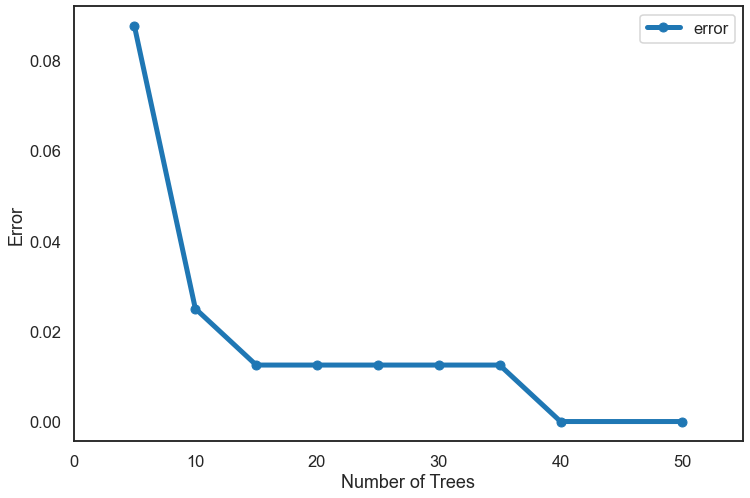

In [116]:
#plot the residuals
sns.set_context('talk')
sns.set_style('white')

# Create the plot
ax = error_df.plot(marker='o', figsize=(12, 8), linewidth=5)

# Set parameters
ax.set(xlabel='Number of Trees', ylabel='Error')
ax.set_xlim(0, max(error_df.index)*1.1);
### END SOLUTION

In [117]:
RC_15 = RandomForestClassifier(n_estimators=15)

RC_15 = RC_15.fit(X_train_rf, y_train_rf)
y_predict_rf_15 = RC.predict(X_test_rf)

In [118]:
#result
print(get_accuracy(X_train_rf, X_test_rf, y_train_rf, y_test_rf, RC_15))

get_correlation(X_test_rf, y_test_rf,EC).style.background_gradient(cmap='coolwarm')

{'test Accuracy': 0.95, 'trian Accuracy': 1.0}
Average correlation between predictors:  0.6101307969064012


,estimator 1,estimator 2,estimator 3,estimator 4,estimator 5
estimator 1,1.000000,0.563389,0.675769,0.677792,0.713410
estimator 2,0.563389,1.000000,0.794777,0.662758,0.769776
estimator 3,0.675769,0.794777,1.000000,0.907649,0.978974
estimator 4,0.677792,0.662758,0.907649,1.000000,0.882341
estimator 5,0.713410,0.769776,0.978974,0.882341,1.000000


### Model Interpretation

#### Permutation Feature Importance

In [121]:
!pip install lime==0.2.0.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 KB 3.1 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=e5fb7977a39b6e16385b3d801114dc5e97a1483db0e8ccdf57e73e73a6c537cd
  Stored in directory: /Users/kristine/Library/Caches/pip/wheels/ed/d7/c9/5a0130d06d6310bc6cbe55220e6e72dcb8c4eff9a478717066
Successfully built lime


In [122]:
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_text, export_graphviz, plot_tree
from sklearn.inspection import permutation_importance, plot_partial_dependence

In [123]:
# Use permutation_importance to calculate permutation feature importances
feature_importances = permutation_importance(estimator=RC_15, X = X_train_rf, y = y_train_rf, n_repeats=5,
                                random_state=123, n_jobs=2)


In [124]:
feature_importances.importances

array([[0.09375, 0.09375, 0.09375, 0.1125 , 0.08125],
       [0.     , 0.     , 0.     , 0.     , 0.     ],
       [0.28125, 0.28125, 0.325  , 0.28125, 0.3125 ],
       [0.075  , 0.06875, 0.05625, 0.075  , 0.1    ],
       [0.5    , 0.4875 , 0.5375 , 0.5375 , 0.45   ]])

In [125]:
def visualize_feature_importance(importance_array):
    # Sort the array based on mean value
    sorted_idx = importance_array.importances_mean.argsort()
    # Visualize the feature importances using boxplot
    fig, ax = plt.subplots()
    fig.set_figwidth(16)
    fig.set_figheight(10)
    fig.tight_layout()
    ax.boxplot(importance_array.importances[sorted_idx].T,
               vert=False, labels=X_train.columns[sorted_idx])
    ax.set_title("Permutation Importances (train set)")
    plt.show()

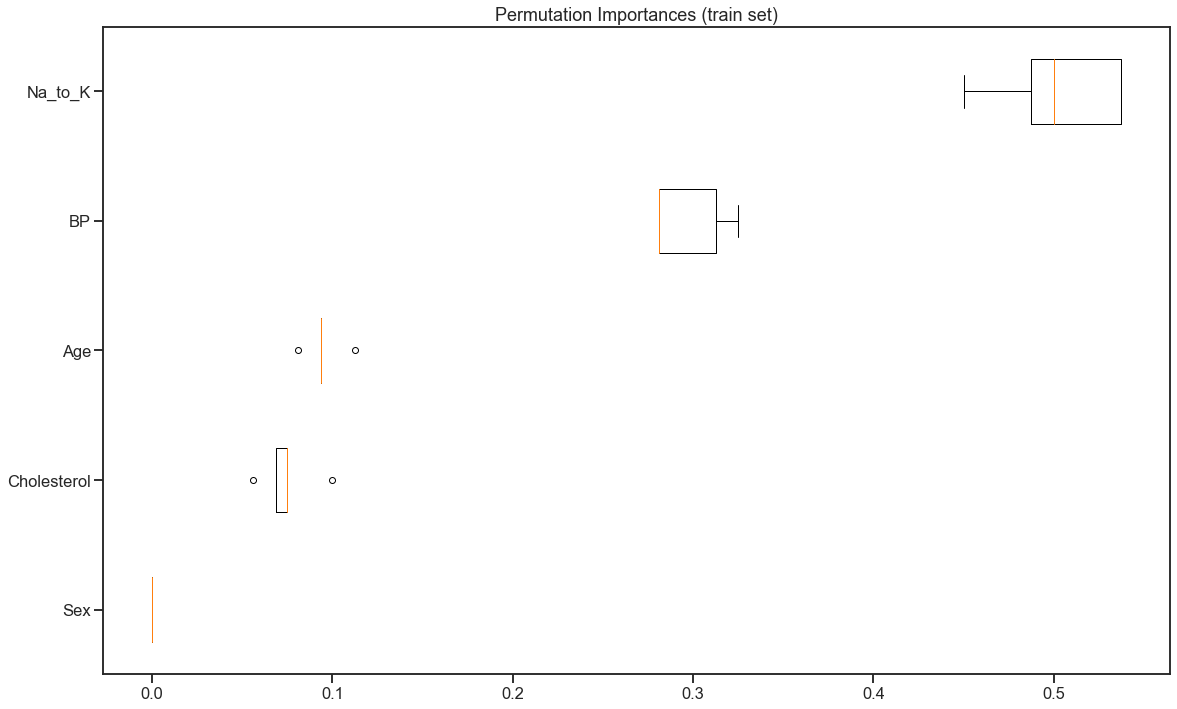

In [126]:
visualize_feature_importance(feature_importances)

#### Partial  Dependency Plot

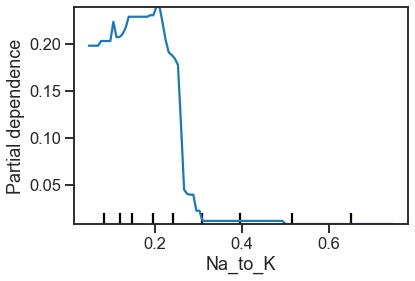

In [134]:
# Important features
important_features = [['Na_to_K']]

plot_partial_dependence(estimator=RC_15, 
                        X=X_train_rf, 
                        features=important_features,
                        target=0,
                        random_state=123)

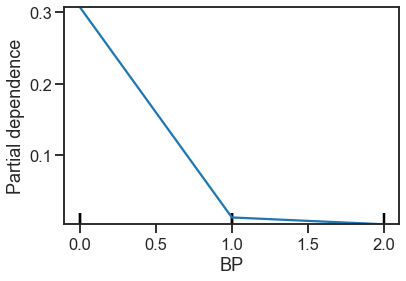

In [135]:
# Important features
important_features_1 = [['BP']]

plot_partial_dependence(estimator=RC_15, 
                        X=X_train_rf, 
                        features=important_features_1,
                        target=0,
                        random_state=123)